In [34]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [35]:
# Load the dataset
df = pd.read_csv("dataset/health_df.csv")

In [36]:
# Calculate BMI, target_weight, and weight_adjustment
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)  # BMI formula
df['target_weight'] = 22 * ((df['height'] / 100) ** 2)  # Assuming normal BMI = 22
df['weight_adjustment'] = df['weight'] - df['target_weight']

# Map gender to numeric
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

# Keep only the relevant columns
df = df[['gender', 'height', 'weight', 'age', 'bmi', 'target_weight', 'weight_adjustment', 'daily_steps', 'bmi_category']]

# One-hot encode bmi_category
df = pd.get_dummies(df, columns=['bmi_category'], drop_first=True)

# Define input features (X) and target (y)
X = df[['gender', 'height', 'weight', 'age']]  # Input features
y = df['daily_steps']  # Target to predict

In [37]:
# Scale features and target
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [38]:
# Model architecture 
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(1))

C:\Users\zahra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mae"])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

In [40]:
# Train the model
history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.2, 
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.4615 - mae: 1.1170 - val_loss: 4.3492 - val_mae: 0.7457 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6779 - mae: 0.9119 - val_loss: 4.1802 - val_mae: 0.6996 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5150 - mae: 0.8866 - val_loss: 4.1081 - val_mae: 0.7132 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0481 - mae: 0.7095 - val_loss: 3.9853 - val_mae: 0.6765 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9010 - mae: 0.6591 - val_loss: 3.8664 - val_mae: 0.6448 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9514 - mae: 0.7134 - val_loss: 3.7424 - val_mae: 0.6249 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6750 - mae: 0.6349 - val_loss: 3.6061 - val_mae: 0.5994 - learning_rate: 0.0010
Epoch 8/100


In [41]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0491 - mae: 0.08458
Test Loss: 0.05100409686565399, Test MAE: 0.08943866938352585


In [42]:
# Make predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# Inverse transform the true values
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [43]:
# Calculate Mean Absolute Error on the inverse-transformed values
mae_test = mean_absolute_error(y_test_inverse, y_pred)
print(f"Mean Absolute Error on Test Set: {mae_test}")

Mean Absolute Error on Test Set: 73.82910766601563


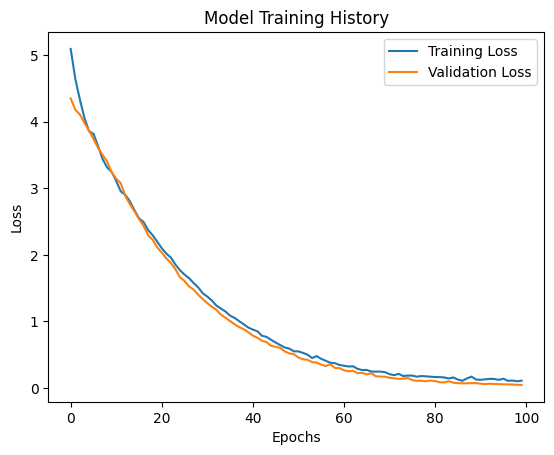

In [44]:
# Plot training history
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Model Training History")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Testing

In [46]:
### Interactive function to test the model in a Jupyter Notebook
def test_model_interactively():
    """
    Prompt the user for input and predict daily_steps along with derived outputs.
    """
    print("Enter the following details for prediction:")
    try:
        # Gather inputs from the user
        gender = int(input("Gender (0 for Male, 1 for Female): "))
        height = float(input("Height (in cm): "))
        weight = float(input("Weight (in kg): "))
        age = int(input("Age (in years): "))
        
        # Calculate BMI and related outputs
        bmi = weight / ((height / 100) ** 2)
        target_weight = 22 * ((height / 100) ** 2)
        weight_adjustment = weight - target_weight
        
        # Prepare input for the model
        new_input = np.array([[gender, height, weight, age]])
        new_input_scaled = scaler_X.transform(new_input)
        
        # Predict daily_steps
        predicted_steps_scaled = model.predict(new_input_scaled)
        predicted_steps = scaler_y.inverse_transform(predicted_steps_scaled).flatten()[0]
        
        # Determine BMI category
        if bmi < 18.5:
            bmi_category = "underweight"
        elif 18.5 <= bmi < 24.9:
            bmi_category = "normal"
        elif 25 <= bmi < 29.9:
            bmi_category = "overweight"
        else:
            bmi_category = "obese"
        
        # Display results
        print("\nPrediction Results:")
        print(f"BMI: {bmi:.2f}")
        print(f"Target Weight: {target_weight:.2f} kg")
        print(f"Weight Adjustment: {weight_adjustment:.2f} kg")
        print(f"Predicted Daily Steps: {predicted_steps:.0f}")
        print(f"BMI Category: {bmi_category}")
    
    except ValueError:
        print("Invalid input. Please enter valid numbers.")

# Run the interactive test
test_model_interactively()

Enter the following details for prediction:


Gender (0 for Male, 1 for Female):  1
Height (in cm):  170
Weight (in kg):  49
Age (in years):  35


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Prediction Results:
BMI: 16.96
Target Weight: 63.58 kg
Weight Adjustment: -14.58 kg
Predicted Daily Steps: 3279
BMI Category: underweight


C:\Users\zahra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [45]:
relative_error = (mae_test / y_test_inverse.mean()) * 100
print(f"Relative Error: {relative_error:.2f}%")

Relative Error: 2.23%
